In [115]:
%matplotlib inline
#Amitava Chakraborty - 05th Jan 2018
#Overview of working with Qiskit

#The fundamental unit of Qiskit is Quantum Circuit. 
#A workflow using Qiskit has two stages: 
#1)Build - make the quantum circuits that represent the problem
#2)Execute - run them on different backends
#After the jobs are run, the data is collected. 

# Importing standard Qiskit libraries and configuring account
import numpy as np
from qiskit import(QuantumRegister,
  QuantumCircuit,
  execute,
  Aer)

from qiskit.quantum_info.synthesis import euler_angles_1q

In [124]:
pauliX = np.array([[0, 1], [1, 0]], dtype=np.complex128)
tolerance = 10e-9

In [103]:
def isUnitary(A):
    #A should be a square matrix, i.e., shape tuple is (n,n), we take the first of the tuple
    n = A.shape[0]
    if (A.shape != (n, n)):
        raise ValueError("Matrix is not square.")
    A = np.array(A)
    #Matrix Mult : A and A-dagger(=A conjugate then transpose)
    B = A @ A.conj().T
    #If A is unitary then B must be an identity matrix
    return np.allclose(np.eye(n), B)


In [131]:
def get_euler_angles_1q(unitary_matrix):
    import scipy.linalg as la
    """
    Find angles (theta, phi, lambda) such that
    unitary_matrix = phase * Rz(phi) * Ry(theta) * Rz(lambda)

    Args:
        unitary_matrix (ndarray): 2x2 unitary matrix

    Returns:
        tuple: (theta, phi, lambda) Euler angles of SU(2)

    """
    phase = la.det(unitary_matrix)**(-1.0/2.0)
    U = phase * unitary_matrix  # U in SU(2)
    # OpenQASM SU(2) parameterization:
    # U[0, 0] = exp(-i(phi+lambda)/2) * cos(theta/2)
    # U[0, 1] = -exp(-i(phi-lambda)/2) * sin(theta/2)
    # U[1, 0] = exp(i(phi-lambda)/2) * sin(theta/2)
    # U[1, 1] = exp(i(phi+lambda)/2) * cos(theta/2)
    theta = 2 * math.atan2(abs(U[1, 0]), abs(U[0, 0]))

    # Find phi and lambda
    phiplambda = 2 * np.angle(U[1, 1])
    phimlambda = 2 * np.angle(U[1, 0])
    phi = (phiplambda + phimlambda) / 2.0
    lamb = (phiplambda - phimlambda) / 2.0

    # Check the solution
    Rzphi = np.array([[np.exp(-1j*phi/2.0), 0],
                      [0, np.exp(1j*phi/2.0)]], dtype=complex)
    Rytheta = np.array([[np.cos(theta/2.0), -np.sin(theta/2.0)],
                        [np.sin(theta/2.0), np.cos(theta/2.0)]], dtype=complex)
    Rzlambda = np.array([[np.exp(-1j*lamb/2.0), 0],
                         [0, np.exp(1j*lamb/2.0)]], dtype=complex)
    V = np.dot(Rzphi, np.dot(Rytheta, Rzlambda))
    if la.norm(V - U) > tolerance:
        raise ValueError("compiling.euler_angles_1q incorrect result norm(V-U)={}".
                          format(la.norm(V-U)))
    return theta, phi, lamb

In [104]:
w = np.exp((2j / 3) * np.pi)
A = np.array([[1, 1, 1, 0], 
                  [1, w, w * w, 0],
                  [1, w * w, w, 0], 
                  [0, 0, 0, -1j*np.sqrt(3)]]) / np.sqrt(3)
print(A)
print (A.shape)

[[ 0.57735027+0.j   0.57735027+0.j   0.57735027+0.j   0.        +0.j ]
 [ 0.57735027+0.j  -0.28867513+0.5j -0.28867513-0.5j  0.        +0.j ]
 [ 0.57735027+0.j  -0.28867513-0.5j -0.28867513+0.5j  0.        +0.j ]
 [ 0.        +0.j   0.        +0.j   0.        +0.j   0.        -1.j ]]
(4, 4)


In [105]:
B= np.array([[-0.21338835+0.33838835j, -0.14016504-0.08838835j,  0.21338835-0.08838835j,
   0.03661165+0.08838835j,  0.08838835-0.03661165j, -0.08838835-0.21338835j,
  -0.08838835+0.14016504j,  0.33838835+0.21338835j,  0.21338835-0.08838835j,
   0.03661165+0.08838835j,  0.39016504+0.08838835j, -0.03661165+0.16161165j,
   0.16161165+0.03661165j,  0.08838835-0.39016504j,  0.08838835-0.03661165j,
  -0.08838835-0.21338835j],
 [-0.14016504-0.08838835j, -0.21338835+0.33838835j,  0.03661165+0.08838835j,
   0.21338835-0.08838835j, -0.08838835-0.21338835j,  0.08838835-0.03661165j,
   0.33838835+0.21338835j, -0.08838835+0.14016504j,  0.03661165+0.08838835j,
   0.21338835-0.08838835j, -0.03661165+0.16161165j,  0.39016504+0.08838835j,
   0.08838835-0.39016504j,  0.16161165+0.03661165j, -0.08838835-0.21338835j,
   0.08838835-0.03661165j],
 [ 0.21338835-0.08838835j,  0.03661165+0.08838835j, -0.21338835+0.33838835j,
  -0.14016504-0.08838835j, -0.08838835+0.14016504j,  0.33838835+0.21338835j,
   0.08838835-0.03661165j, -0.08838835-0.21338835j,  0.39016504+0.08838835j,
  -0.03661165+0.16161165j,  0.21338835-0.08838835j,  0.03661165+0.08838835j,
   0.08838835-0.03661165j, -0.08838835-0.21338835j,  0.16161165+0.03661165j,
   0.08838835-0.39016504j],
 [ 0.03661165+0.08838835j,  0.21338835-0.08838835j, -0.14016504-0.08838835j,
  -0.21338835+0.33838835j,  0.33838835+0.21338835j, -0.08838835+0.14016504j,
  -0.08838835-0.21338835j,  0.08838835-0.03661165j, -0.03661165+0.16161165j,
   0.39016504+0.08838835j,  0.03661165+0.08838835j,  0.21338835-0.08838835j,
  -0.08838835-0.21338835j,  0.08838835-0.03661165j,  0.08838835-0.39016504j,
   0.16161165+0.03661165j],
 [ 0.08838835-0.03661165j, -0.08838835-0.21338835j, -0.08838835+0.14016504j,
   0.33838835+0.21338835j, -0.21338835+0.33838835j, -0.14016504-0.08838835j,
   0.21338835-0.08838835j,  0.03661165+0.08838835j,  0.16161165+0.03661165j,
   0.08838835-0.39016504j,  0.08838835-0.03661165j, -0.08838835-0.21338835j,
   0.21338835-0.08838835j,  0.03661165+0.08838835j,  0.39016504+0.08838835j,
  -0.03661165+0.16161165j],
 [-0.08838835-0.21338835j,  0.08838835-0.03661165j,  0.33838835+0.21338835j,
  -0.08838835+0.14016504j, -0.14016504-0.08838835j, -0.21338835+0.33838835j,
   0.03661165+0.08838835j,  0.21338835-0.08838835j,  0.08838835-0.39016504j,
   0.16161165+0.03661165j, -0.08838835-0.21338835j,  0.08838835-0.03661165j,
   0.03661165+0.08838835j,  0.21338835-0.08838835j, -0.03661165+0.16161165j,
   0.39016504+0.08838835j],
 [-0.08838835+0.14016504j,  0.33838835+0.21338835j,  0.08838835-0.03661165j,
  -0.08838835-0.21338835j,  0.21338835-0.08838835j,  0.03661165+0.08838835j,
  -0.21338835+0.33838835j, -0.14016504-0.08838835j,  0.08838835-0.03661165j,
  -0.08838835-0.21338835j,  0.16161165+0.03661165j,  0.08838835-0.39016504j,
   0.39016504+0.08838835j, -0.03661165+0.16161165j,  0.21338835-0.08838835j,
   0.03661165+0.08838835j],
 [ 0.33838835+0.21338835j, -0.08838835+0.14016504j, -0.08838835-0.21338835j,
   0.08838835-0.03661165j,  0.03661165+0.08838835j,  0.21338835-0.08838835j,
  -0.14016504-0.08838835j, -0.21338835+0.33838835j, -0.08838835-0.21338835j,
   0.08838835-0.03661165j,  0.08838835-0.39016504j,  0.16161165+0.03661165j,
  -0.03661165+0.16161165j,  0.39016504+0.08838835j,  0.03661165+0.08838835j,
   0.21338835-0.08838835j],
 [ 0.21338835-0.08838835j,  0.03661165+0.08838835j,  0.39016504+0.08838835j,
  -0.03661165+0.16161165j,  0.16161165+0.03661165j,  0.08838835-0.39016504j,
   0.08838835-0.03661165j, -0.08838835-0.21338835j, -0.21338835+0.33838835j,
  -0.14016504-0.08838835j,  0.21338835-0.08838835j,  0.03661165+0.08838835j,
   0.08838835-0.03661165j, -0.08838835-0.21338835j, -0.08838835+0.14016504j,
   0.33838835+0.21338835j],
 [ 0.03661165+0.08838835j,  0.21338835-0.08838835j, -0.03661165+0.16161165j,
   0.39016504+0.08838835j,  0.08838835-0.39016504j,  0.16161165+0.03661165j,
  -0.08838835-0.21338835j,  0.08838835-0.03661165j, -0.14016504-0.08838835j,
  -0.21338835+0.33838835j,  0.03661165+0.08838835j,  0.21338835-0.08838835j,
  -0.08838835-0.21338835j,  0.08838835-0.03661165j,  0.33838835+0.21338835j,
  -0.08838835+0.14016504j],
 [ 0.39016504+0.08838835j, -0.03661165+0.16161165j,  0.21338835-0.08838835j,
   0.03661165+0.08838835j,  0.08838835-0.03661165j, -0.08838835-0.21338835j,
   0.16161165+0.03661165j,  0.08838835-0.39016504j,  0.21338835-0.08838835j,
   0.03661165+0.08838835j, -0.21338835+0.33838835j, -0.14016504-0.08838835j,
  -0.08838835+0.14016504j,  0.33838835+0.21338835j,  0.08838835-0.03661165j,
  -0.08838835-0.21338835j],
 [-0.03661165+0.16161165j,  0.39016504+0.08838835j,  0.03661165+0.08838835j,
   0.21338835-0.08838835j, -0.08838835-0.21338835j,  0.08838835-0.03661165j,
   0.08838835-0.39016504j,  0.16161165+0.03661165j,  0.03661165+0.08838835j,
   0.21338835-0.08838835j, -0.14016504-0.08838835j, -0.21338835+0.33838835j,
   0.33838835+0.21338835j, -0.08838835+0.14016504j, -0.08838835-0.21338835j,
   0.08838835-0.03661165j],
 [ 0.16161165+0.03661165j,  0.08838835-0.39016504j,  0.08838835-0.03661165j,
  -0.08838835-0.21338835j,  0.21338835-0.08838835j,  0.03661165+0.08838835j,
   0.39016504+0.08838835j, -0.03661165+0.16161165j,  0.08838835-0.03661165j,
  -0.08838835-0.21338835j, -0.08838835+0.14016504j,  0.33838835+0.21338835j,
  -0.21338835+0.33838835j, -0.14016504-0.08838835j,  0.21338835-0.08838835j,
   0.03661165+0.08838835j],
 [ 0.08838835-0.39016504j,  0.16161165+0.03661165j, -0.08838835-0.21338835j,
   0.08838835-0.03661165j,  0.03661165+0.08838835j,  0.21338835-0.08838835j,
  -0.03661165+0.16161165j,  0.39016504+0.08838835j, -0.08838835-0.21338835j,
   0.08838835-0.03661165j,  0.33838835+0.21338835j, -0.08838835+0.14016504j,
  -0.14016504-0.08838835j, -0.21338835+0.33838835j,  0.03661165+0.08838835j,
   0.21338835-0.08838835j],
 [ 0.08838835-0.03661165j, -0.08838835-0.21338835j,  0.16161165+0.03661165j,
   0.08838835-0.39016504j,  0.39016504+0.08838835j, -0.03661165+0.16161165j,
   0.21338835-0.08838835j,  0.03661165+0.08838835j, -0.08838835+0.14016504j,
   0.33838835+0.21338835j,  0.08838835-0.03661165j, -0.08838835-0.21338835j,
   0.21338835-0.08838835j,  0.03661165+0.08838835j, -0.21338835+0.33838835j,
  -0.14016504-0.08838835j],
 [-0.08838835-0.21338835j,  0.08838835-0.03661165j,  0.08838835-0.39016504j,
   0.16161165+0.03661165j, -0.03661165+0.16161165j,  0.39016504+0.08838835j,
   0.03661165+0.08838835j,  0.21338835-0.08838835j,  0.33838835+0.21338835j,
  -0.08838835+0.14016504j, -0.08838835-0.21338835j,  0.08838835-0.03661165j,
   0.03661165+0.08838835j,  0.21338835-0.08838835j, -0.14016504-0.08838835j,
  -0.21338835+0.33838835j]])

In [106]:
isUnitary(A)

True

In [107]:
isUnitary(B)

True

In [162]:
import math

class Gate3:
    """Represents a U3 gate acting on one qubit.
    """
    def __init__(self, name, arg=None):
        assert name in ['U3']
        self.name = name
        self.arg = arg

    def to_matrix(self):
        if self.name == 'U3':
            return np.array([[np.cos(self.arg / 2), np.sin(self.arg / 2)],
                             [-np.sin(self.arg / 2), np.cos(self.arg / 2)]])
        elif self.name == 'Rz':
            return np.diag([np.exp(0.5j * self.arg), np.exp(-0.5j * self.arg)])
        elif self.name == 'R1':
            return np.diag([1.0, np.exp(1j * self.arg)])
        elif self.name == 'X':
            return PAULI_X

class Gate2:
    """Represents gate acting on one qubit.
    Definitions:
    Ry(a) = exp(0.5*i*a*sigma_y)
    Rz(a) = exp(0.5*i*a*sigma_z)
    R1(a) = diag(1, exp(i*a))
    """

    def __init__(self, name, arg=None):
        assert name in ['Ry', 'Rz', 'R1', 'X']
        self.name = name
        self.arg = arg

    def to_matrix(self):
        if self.name == 'Ry':
            return np.array([[np.cos(self.arg / 2), np.sin(self.arg / 2)],
                             [-np.sin(self.arg / 2), np.cos(self.arg / 2)]])
        elif self.name == 'Rz':
            return np.diag([np.exp(0.5j * self.arg), np.exp(-0.5j * self.arg)])
        elif self.name == 'R1':
            return np.diag([1.0, np.exp(1j * self.arg)])
        elif self.name == 'X':
            return PAULI_X

    def is_identity(self):
        return np.allclose(self.to_matrix(), np.eye(2))

    def __repr__(self):
        if self.arg is not None:
            return self.name + "(" + str(self.arg) + ")"
        else:
            return self.name




class GateFC():
    """ Represents fully contolled gate.
    `flip_mask` has ones at positions, for which qubit should be flipped before
    and after applying operation.
    """

    def __init__(self, gate2, qubit_id, qubit_count, flip_mask=0):
        self.gate2 = gate2
        self.qubit_id = qubit_id
        self.flip_mask = flip_mask
        self.qubit_count = qubit_count

    def without_flips(self):
        return GateFC(self.gate2, self.qubit_id, self.qubit_count, flip_mask=0)

    def to_matrix(self):
        matrix_size = 2**self.qubit_count
        index2 = (matrix_size - 1) - self.flip_mask
        index1 = index2 - 2**self.qubit_id
        matrix = TwoLevelUnitary(
            self.gate2.to_matrix(),
            matrix_size,
            index1,
            index2)
        return matrix.get_full_matrix()

    def __repr__(self):
        theta = self.gate2[0]
        phi = self.gate2[1]
        lambda1 = self.gate2[2]
        return "qc.u3(%s, %s, %s, %d), %s, %s" % (theta,phi,lambda1,self.qubit_id, self.qubit_count, self.flip_mask)
        #return "%s on bit %d, fully controlled" % (
        #    str(self.gate2), self.qubit_id)

    def type(self):
        return self.gate2.name + "-FC"


def gates_to_matrix(gates):
    """Converts gate sequence to matrix implemented by this sequence."""
    result = np.eye(2 ** gates[0].qubit_count)
    for gate in gates:
        assert isinstance(gate, Gate)
        result = gate.to_matrix() @ result
    return result


def apply_on_qubit(gates, qubit_id, qubit_count):
    """Converts Gate2 gates to GateSingle gates acting on the same qubit."""
    return [GateSingle(gate, qubit_id, qubit_count) for gate in gates]



def su_to_gates(A):
    """Decomposes 2x2 special unitary to gates Ry, Rz.
    R_k(x) = exp(0.5*i*x*sigma_k).
    """
    #assert is_special_unitary(A)
    u00 = A[0, 0]
    u01 = A[0, 1]
    theta = np.arccos(np.abs(u00))
    lmbda = np.angle(u00)
    mu = np.angle(u01)

    result = []
    result.append(Gate2('Rz', lmbda - mu))
    result.append(Gate2('Ry', 2 * theta))
    result.append(Gate2('Rz', lmbda + mu))
    return result

#AMC
def unitary2x2_to_U3(A):
    """Decomposes 2x2 unitary to U3 gate
    """
    theta, phi, lambda1 = get_euler_angles_1q(A)
    return np.array([theta, phi, lambda1])

def unitary2x2_to_gates(A):
    """Decomposes 2x2 unitary to gates Ry, Rz, R1.
    R1(x) = diag(1, exp(i*x)).
    """
    phi = np.angle(np.linalg.det(A))
    if np.abs(phi) < 1e-9:
        return su_to_gates(A)
    elif np.allclose(A, PAULI_X):
        return [Gate2('X')]
    else:
        A = np.diag([1.0, np.exp(-1j * phi)]) @ A
        return su_to_gates(A) + [Gate2('R1', phi)]

    
    

def rearrange_for_merge(gates):
    """Rearranges gates, so mergeable gates are next to each other.
    Swaps only 1-qubit gates acting on different qubits, which always commute.
    """
    n = len(gates)
    result = []
    taken = [False] * n
    pos = 0
    while(pos != n):
        if taken[pos]:
            pos += 1
        elif isinstance(gates[pos], GateFC):
            result.append(gates[pos])
            taken[pos] = True
            pos += 1
        else:
            assert isinstance(gates[pos], GateSingle)
            # Take first gate with minimal qubit_id.
            to_take = pos
            for i in range(pos + 1, n):
                if taken[i]:
                    continue
                if isinstance(gates[i], GateFC):
                    break
                assert isinstance(gates[i], GateSingle)
                if gates[i].qubit_id < gates[to_take].qubit_id:
                    to_take = i
            result.append(gates[to_take])
            taken[to_take] = True

    assert len(result) == n
    return result


def merge_same_gates(gates):
    def can_merge(g1, g2):
        """Checks if gates can be merged."""
        assert (g1.qubit_count == g2.qubit_count)
        if isinstance(g1, GateSingle) and isinstance(g2, GateSingle):
            if (g1.qubit_id != g2.qubit_id):
                return False
        else:
            return False
        if g1.gate2.name not in ['Rx', 'Ry', 'Rz', 'R1']:
            return False
        return g1.gate2.name == g2.gate2.name

    def merge_gates(g1, g2):
        assert can_merge(g1, g2)
        new_gate2 = Gate2(g1.gate2.name, arg=g1.gate2.arg + g2.gate2.arg)
        return GateSingle(new_gate2, g1.qubit_id, g1.qubit_count)

    if len(gates) == 0:
        return []

    result = []
    cur_gate = gates[0]
    for gate in gates[1:]:
        if can_merge(cur_gate, gate):
            cur_gate = merge_gates(cur_gate, gate)
        else:
            result.append(cur_gate)
            cur_gate = gate
    result.append(cur_gate)
    return result


def skip_identities(gates):
    return [gate for gate in gates if not gate.gate2.is_identity()]
def optimize_gates(gates):
    """
    Applies equivalent optimizations to sequence of gates.
    Merges adjacent Rx, Ry, Rz and R1 gates.
    Cancels consequent NOT gates.
    Skips identity gates.
    After execution all fully controlled gates will have `flip_mask=0`.
    """
    qubit_count = gates[0].qubit_count
    for gate in gates:
        assert gate.qubit_count == qubit_count

    result = []

    global flip_mask
    flip_mask = 0

    def dump_flips():
        global flip_mask
        for qubit_id in range(qubit_count):
            if (flip_mask & (2**qubit_id)) != 0:
                result.append(GateSingle(Gate2('X'), qubit_id, qubit_count))
        flip_mask = 0

    for gate in gates:
        '''
        if isinstance(gate, GateSingle):
            if gate.gate2.name == 'X':
                flip_mask ^= 2**gate.qubit_id
            elif gate.gate2.is_identity():
                pass
            else:
                dump_flips()
                result.append(gate)
        else:
        '''
        assert isinstance(gate, GateFC)
        if gate.gate2.is_identity():
            pass
        else:
            flip_mask ^= gate.flip_mask
            dump_flips()
            result.append(gate.without_flips())
            flip_mask ^= gate.flip_mask
        dump_flips()

        result = rearrange_for_merge(result)
        result = merge_same_gates(result)
        result = skip_identities(result)

        return result    
    
    

class TwoLevelUnitary:
    """Represents two-level unitary matrix.
    Two-level uniary matrix is a unitary matrix obtained from the identity
    matrix by changing a 2x2 principal submatrix.
    """

    def __init__(self, matrix2x2, matrix_size, index1, index2):
        assert index1 != index2
        assert index1 < matrix_size and index2 < matrix_size
        assert matrix2x2.shape == (2, 2)
        assert isUnitary(matrix2x2)

        self.matrix_size = matrix_size
        self.index1 = index1
        self.index2 = index2
        self.matrix_2x2 = matrix2x2
        self.order_indices()

    def __repr__(self):
        self.order_indices()
        return "%s on (%d, %d)" % (
            str(self.matrix_2x2), self.index1, self.index2)

    def order_indices(self):
        if self.index1 > self.index2:
            self.index1, self.index2 = self.index2, self.index1
            self.matrix_2x2 = PAULI_X @ self.matrix_2x2 @ PAULI_X

    def get_full_matrix(self):
        matrix_full = np.eye(self.matrix_size, dtype=np.complex128)
        matrix_full[self.index1, self.index1] = self.matrix_2x2[0, 0]
        matrix_full[self.index1, self.index2] = self.matrix_2x2[0, 1]
        matrix_full[self.index2, self.index1] = self.matrix_2x2[1, 0]
        matrix_full[self.index2, self.index2] = self.matrix_2x2[1, 1]
        return matrix_full

    def multiply_right(self, A):
        """M.multiply_right(A) is equivalent to A = A @ M.get_full_matrix()."""
        idx = (self.index1, self.index2)
        A[:, idx] = A[:, idx] @ self.matrix_2x2

    def inv(self):
        return TwoLevelUnitary(self.matrix_2x2.conj().T,
                               self.matrix_size,
                               self.index1,
                               self.index2)

    def apply_permutation(self, perm):
        assert(len(perm) == self.matrix_size)
        self.index1 = perm[self.index1]
        self.index2 = perm[self.index2]

    def to_fc_gates(self):
        """Returns list of fully controlled gates implementing this matrix."""
        #from src.gate import GateFC

        self.order_indices()
        qubit_id_mask = self.index1 ^ self.index2
        #assert is_power_of_two(qubit_id_mask)
        assert self.index1 < self.index2

        qubit_id = int(math.log2(qubit_id_mask))
        flip_mask = (self.matrix_size - 1) - self.index2
        qubit_count = int(math.log2(self.matrix_size))

        return [GateFC(gate2, qubit_id, qubit_count, flip_mask=flip_mask)
                for gate2 in unitary2x2_to_gates(self.matrix_2x2)]

    def to_fc_gates1(self):
        """Returns list of fully controlled gates implementing this matrix."""
        #from src.gate import GateFC

        self.order_indices()
        qubit_id_mask = self.index1 ^ self.index2
        #assert is_power_of_two(qubit_id_mask)
        assert self.index1 < self.index2

        qubit_id = int(math.log2(qubit_id_mask))
        flip_mask = (self.matrix_size - 1) - self.index2
        qubit_count = int(math.log2(self.matrix_size))

        #return [GateFC(gate2, qubit_id, qubit_count, flip_mask=flip_mask)
        #        for gate2 in unitary2x2_to_U3(self.matrix_2x2)]
        return [GateFC(unitary2x2_to_U3(self.matrix_2x2), qubit_id, qubit_count, flip_mask=flip_mask)]
    


In [110]:
def decompose(unitaryA):
    """Returns a list of two-level (2x2) unitary matrices that multiply to A.
    Matrices are listed in application order. 
    If result is [u1, u2, u3], it means A = u3 @ u2 @ u1
    """
    def make_eliminating_matrix(a, b):
        """Returns unitary matrix U, s.t. [a, b] U = [c, 0].
        Makes second element equal to zero.
        """
        assert (np.abs(a) > tolerance and np.abs(b) > tolerance)
        theta = np.arctan(np.abs(b / a))
        lambda1 = -np.angle(a)
        mu = np.pi + np.angle(b) - np.angle(a) - lambda1
        result = np.array([[np.cos(theta) * np.exp(1j * lambda1),
                            np.sin(theta) * np.exp(1j * mu)],
                           [-np.sin(theta) * np.exp(-1j * mu),
                            np.cos(theta) * np.exp(-1j * lambda1)]])

        assert np.allclose(np.angle(result[0, 0] * a + result[1, 0] * b), 0)
        assert (np.abs(result[0, 1] * a + result[1, 1] * b) < tolerance)
        return result

    #A should be a square matrix, i.e., shape tuple is (n,n), we take the first of the tuple
    A = unitaryA
    n = A.shape[0]
    result = []
    # Make a copy of A, because A will change
    current_A = np.array(A)

    for i in range(n - 2):
        for j in range(n - 1, i, -1):
            if abs(current_A[i, j]) < tolerance:
                # Element is already zero, skipping.
                pass
            else:
                if abs(current_A[i, j - 1]) < tolerance:
                    # Just swap columns.
                    u_2x2 = pauliX
                else:
                    u_2x2 = make_eliminating_matrix(
                        current_A[i, j - 1], current_A[i, j])
                u_2x2 = TwoLevelUnitary(u_2x2, n, j - 1, j)
                u_2x2.multiply_right(current_A)
                result.append(u_2x2.inv())

    result.append(TwoLevelUnitary(
        current_A[n - 2:n, n - 2:n], n, n - 2, n - 1))
    return result


In [134]:
twoLevelMatrices = two_level_decompose(B)

In [135]:
print(twoLevelMatrices)
print(len(twoLevelMatrices))

[[[ 0.3535534-0.1464466j  -0.3535534-0.85355339j]
 [ 0.3535534-0.85355339j  0.3535534+0.1464466j ]] on (14, 15), [[ 0.18736556-8.27071548e-01j  0.52994981-6.49001341e-17j]
 [-0.52994981-6.49001341e-17j  0.18736556+8.27071548e-01j]] on (13, 14), [[ 0.3232233 +7.32233002e-02j  0.94348558-1.15543660e-16j]
 [-0.94348558-1.15543660e-16j  0.3232233 -7.32233002e-02j]] on (12, 13), [[-0.06950565+3.06812791e-01j  0.94922857-1.16246973e-16j]
 [-0.94922857-1.16246973e-16j -0.06950565-3.06812791e-01j]] on (11, 12), [[ 0.5898741 +1.33630625e-01j  0.79636135+2.56129346e-16j]
 [-0.79636135+2.56129346e-16j  0.5898741 -1.33630625e-01j]] on (10, 11), [[ 0.05478154+1.32254343e-01j  0.98970085-1.21203398e-16j]
 [-0.98970085-1.21203398e-16j  0.05478154-1.32254343e-01j]] on (9, 10), [[ 0.3017767 -1.25000004e-01j  0.94514857-1.15747317e-16j]
 [-0.94514857-1.15747317e-16j  0.3017767 +1.25000004e-01j]] on (8, 9), [[ 0.41651425+2.62654692e-01j  0.87036107-1.06588490e-16j]
 [-0.87036107-1.06588490e-16j  0.416514

In [25]:
def two_level_decompose_gray(A):
    """Retunrs list of two-level matrices, which multiplu to A.
    Guarantees that each matrix acts on single bit.
    """
    N = A.shape[0]
    #assert is_power_of_two(N)
    #assert A.shape == (N, N), "Matrix must be square."
    #assert isUnitary(A)

    # Build permutation matrix.
    perm = [x ^ (x // 2) for x in range(N)]  # Gray code.
    P = np.zeros((N, N), dtype=np.complex128)
    for i in range(N):
        P[i][perm[i]] = 1

    result = two_level_decompose(P @ A @ P.T)
    for matrix in result:
        matrix.apply_permutation(perm)
    return result

In [60]:
def matrix_to_gates(A, **kwargs):
    """Given unitary matrix A, retuns sequence of gates which implements
    action of this matrix on register of qubits.
    Input: A - 2^n x 2^N unitary matrix.
    Returns: sequence of `Gate`s.
    If optimized=True, applies optimized algorithm yielding less gates. Will
    affect output only when A is 4x4 matrix.
    """
    if 'optimize' in kwargs and kwargs['optimize'] and A.shape[0] == 4:
        return decompose_4x4_optimal(A)

    matrices = two_level_decompose_gray(A)
    gates = sum([matrix.to_fc_gates() for matrix in matrices], [])
    #gates = optimize_gates(gates)
    return gates

In [61]:
gates = matrix_to_gates(B)
print('\n'.join(map(str, gates)))

Rz(1.570796289167992) on bit 0, fully controlled
Ry(2.3561944901923444) on bit 0, fully controlled
Rz(-3.9269908435934804) on bit 0, fully controlled
Rz(1.3480157105287576) on bit 1, fully controlled
Ry(1.970913155897291) on bit 1, fully controlled
Rz(-4.935169596650828) on bit 1, fully controlled
Rz(0.22278063433128842) on bit 0, fully controlled
Ry(1.2866583704108874) on bit 0, fully controlled
Rz(0.2227806343312882) on bit 0, fully controlled
Rz(3.534291703171945) on bit 2, fully controlled
Ry(2.7634794576421142) on bit 2, fully controlled
Rz(-2.748893604007641) on bit 2, fully controlled
Rz(-1.1780972395858398) on bit 0, fully controlled
Ry(2.289724695865582) on bit 0, fully controlled
Rz(5.105088067593746) on bit 0, fully controlled
Rz(-1.3480156924636082) on bit 1, fully controlled
Ry(1.8993092473472002) on bit 1, fully controlled
Rz(-1.3480156924636086) on bit 1, fully controlled
Rz(0.22278061626613907) on bit 0, fully controlled
Ry(2.668503598979189) on bit 0, fully controlled


In [ ]:
#How to implement this operator R in Qiskit?

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, execute
from qiskit.quantum_info.operators import Operator

qr = QuantumRegister(1)
cr = ClassicalRegister(1)
circuit = QuantumCircuit(qr,cr)
'''
cx = Operator([
    [1, 0, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0]
])
'''
r = Operator(R)
#circuit.unitary(cx, [0, 1], label='cx')
circuit.x([0])
circuit.unitary(r, [0], label='R')
circuit.measure(qr,cr)
circuit.draw('mpl')

In [163]:
gates = sum([matrix.to_fc_gates1() for matrix in twoLevelMatrices], [])
print('\n'.join(map(str, gates)))
#print(gates)


qc.u3(2.3561944901923444, -0.7853981900036875, 1.570796289167992, 0), 4, 0
qc.u3(1.1170827652008883, -1.7935769611261847, 4.4896083460534015, 1), 4, 1
qc.u3(2.4659898074179067, -3.364373269855932, 2.9188120373236544, 0), 4, 2
qc.u3(2.5015491081549768, -4.935169596650828, 1.3480157105287576, 2), 4, 3
qc.u3(1.8425101842032825, 2.918812019258505, -3.3643732879210813, 0), 4, 4
qc.u3(2.8543035615826797, -4.319689930802538, 1.9634953763770489, 1), 4, 5
qc.u3(2.4760983034062556, -2.7488935663807363, 3.53429174079885, 0), 4, 6
qc.u3(2.11187023081304, -3.704210191852356, 2.5789751153272302, 3), 4, 7
qc.u3(2.7391831911050377, 1.008178768885121, -5.275006538294465, 0), 4, 8
qc.u3(2.598246563838691, -1.1780972395858393, 5.105088067593746, 1), 4, 9
qc.u3(2.92019838960337, 3.534291703171945, -2.74889360400764, 0), 4, 10
qc.u3(2.9215425289269255, -4.319689930802537, 1.9634953763770484, 2), 4, 11
qc.u3(2.623335992123607, 3.53429174079885, -2.7488935663807363, 0), 4, 12
qc.u3(2.7779821501008968, 5.7205

In [87]:
from qiskit.quantum_info.synthesis import euler_angles_1q, one_qubit_decompose
from qiskit.quantum_info.synthesis.one_qubit_decompose import OneQubitEulerDecomposer
import math
from scipy.linalg import sqrtm 
import numpy as np 

x_matrix = np.array([[0, 1], [1, 0]]) 
x_90_matrix = sqrtm(x_matrix)
# Returns (theta, phi, lambda) 
euler_angles_1q(x_90_matrix)                                                                        

an_matr = np.array([[-1/np.sqrt(2), 1j/np.sqrt(2)], [1j/np.sqrt(2), -1/np.sqrt(2)]])
euler_angles_1q(an_matr)

(1.5707963267948966, 4.71238898038469, 1.5707963267948966)

In [71]:
qc = QuantumCircuit(1)
qc.rx(1,0)
backend = Aer.get_backend('unitary_simulator')
result = execute(qc, backend).result()
print(result.get_unitary())
theta, phi, lambda1 = euler_angles_1q(result.get_unitary())
print('theta: ', theta, 'phi: ', phi, 'lambda: ',lambda1)

[[ 8.77582562e-01+0.j         -2.93563476e-17-0.47942554j]
 [ 2.93563476e-17-0.47942554j  8.77582562e-01+0.j        ]]
theta:  1.0 phi:  -1.5707963267948966 lambda:  1.5707963267948966


In [72]:
qc = QuantumCircuit(1)
qc.u3(theta,phi,lambda1,0)
backend = Aer.get_backend('unitary_simulator')
result = execute(qc, backend).result()
print(result.get_unitary())

[[ 8.77582562e-01+0.j         -2.93563476e-17-0.47942554j]
 [ 2.93563476e-17-0.47942554j  8.77582562e-01+0.j        ]]


In [91]:
for matrix in twoLevelMatrices:
    #print (matrix.matrix_2x2)
    theta, phi, lambda1 = euler_angles_1q(matrix.matrix_2x2)
    print('qc.u3(',theta,',',phi,',',lambda1,',0)')

qc.u3( 2.3561944901923444 , -0.7853981900036875 , 1.570796289167992 ,0)
qc.u3( 1.1170827652008883 , -1.7935769611261847 , 4.4896083460534015 ,0)
qc.u3( 2.4659898074179067 , -3.364373269855932 , 2.9188120373236544 ,0)
qc.u3( 2.5015491081549768 , -4.935169596650828 , 1.3480157105287576 ,0)
qc.u3( 1.8425101842032825 , 2.918812019258505 , -3.3643732879210813 ,0)
qc.u3( 2.8543035615826797 , -4.319689930802538 , 1.9634953763770489 ,0)
qc.u3( 2.4760983034062556 , -2.7488935663807363 , 3.53429174079885 ,0)
qc.u3( 2.11187023081304 , -3.704210191852356 , 2.5789751153272302 ,0)
qc.u3( 2.7391831911050377 , 1.008178768885121 , -5.275006538294465 ,0)
qc.u3( 2.598246563838691 , -1.1780972395858393 , 5.105088067593746 ,0)
qc.u3( 2.92019838960337 , 3.534291703171945 , -2.74889360400764 ,0)
qc.u3( 2.9215425289269255 , -4.319689930802537 , 1.9634953763770484 ,0)
qc.u3( 2.623335992123607 , 3.53429174079885 , -2.7488935663807363 ,0)
qc.u3( 2.7779821501008968 , 5.7205677492698115 , -0.5626175579097752 ,0)
q

QiskitError: 'compiling.euler_angles_1q incorrect result norm(V-U)=7.071067725730222e-09'

In [15]:
#Simulating circuits using Qiskit Aer 
# Import Aer
from qiskit import BasicAer

#Qiskit Aer provides many different backends for simulation
#Here we use the basic python version - Statevector backend - the most common backend in Qiskit Aer.

#To run the above circuit using the statevector simulator, set the backend to statevector_simulator.
backend = BasicAer.get_backend('statevector_simulator')

#This simulator returns the quantum state which is 
#a complex vector of dimensions 2^n for n qubits 

#When representing the state of a multi-qubit system, 
#the tensor order used in qiskit is different than that used in most physics textbooks. 
#For n qubits, qubit j is labeled as Q_{j}. 
#Qiskit uses an ordering in which the n^{\mathrm{th}} qubit is on the left side of the tensor product, 
#so that the basis vectors are labeled as  Q_n tensor_cross Q_(n-1) tensor_cross .. Q_0. 
#For example, if qubit zero is in state 0, qubit 1 is in state 0, and qubit 2 is in state 1, 
#qiskit would represent this state as |100> 
#whereas many physics textbooks would represent it as |001>
#This difference in labeling affects the way multi-qubit operations are represented as matrices. 
#For example, qiskit represents a controlled-X (CX) operation with 
#qubit 0 being the control and qubit 1 being the target 
#as CX = [[1,0,0,0], [0,0,0,1], [0,0,1,0], [0,1,0,0]]

#Now we compile and run the quantum circuit - the execute function
#it returns a job object that encapsulates information about the job submitted to the backend.
#In Jupyter - Simply place the text cursor on a function and press Shift+Tab.

# Create a Quantum Program for execution 
job = execute(circ, backend)

[0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 1.+0.j]


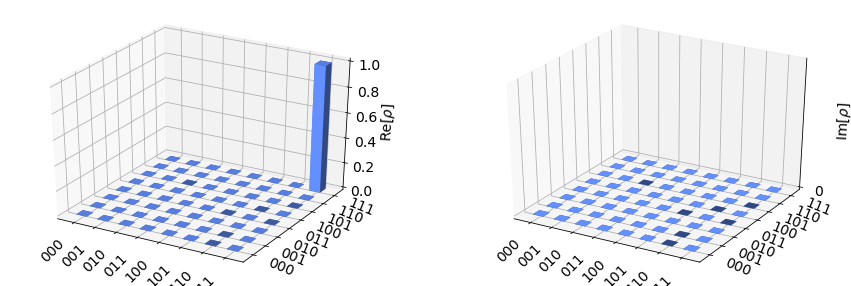

In [16]:
#The job object has 
#job.status() and 
#job.result()

#Note: Jobs run asynchronously but when the result method is called it switches to synchronous and 
#waits for it to finish before moving on to another task.
result = job.result()

#The results object contains the data and 
#result.get_statevector(circ) - returns the state vector for the quantum circuit.
outputstate = result.get_statevector(circ, decimals=3)
print(outputstate)

#Qiskit also provides a visualization toolbox to allow you to view these results.
#Use visualization function to plot the real and imaginary components of the state vector.
from qiskit.visualization import plot_state_city
plot_state_city(outputstate)

In [17]:
#Unitary backend
#Qiskit Aer also includes a unitary_simulator 
#that works provided all the elements in the circuit are unitary operations. 
#This backend calculates the 2^n X 2^n matrix representing the gates in the quantum circuit.

# Run the quantum circuit on a unitary simulator backend
backend = BasicAer.get_backend('unitary_simulator')
job = execute(circ, backend)
result = job.result()

# Show the results
print(result.get_unitary(circ, decimals=3))

BasicAerError: 'Unsupported "%s" instruction "%s" in circuit "%s"  unitary_simulator measure circuit7'

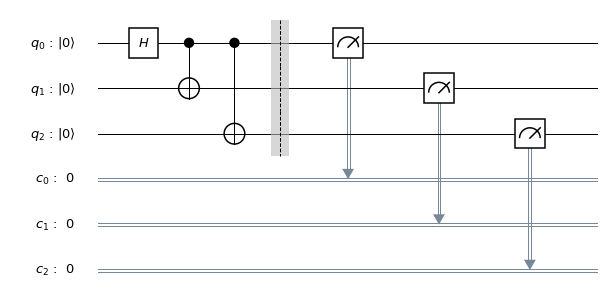

In [14]:
#OpenQASM backend
#The simulators above are useful because they provide information 
#about the state output by the ideal circuit and the matrix representation of the circuit. 
#However, a real experiment terminates by measuring each qubit 
#(usually in the computational $|0\rangle, |1\rangle$ basis). 
#Without measurement, we cannot gain information about the state. 
#Measurements cause the quantum system to collapse into classical bits.

#For example, suppose we make independent measurements on each qubit of the three-qubit GHZ state 
#$$|\psi\rangle = |000\rangle +|111\rangle)/\sqrt{2},$$ and 
#let $xyz$ denote the bitstring that results. 
#Recall that, under the qubit labeling used by Qiskit, 
#$x$ would correspond to the outcome on qubit 2, 
#$y$ to the outcome on qubit 1, and 
#$z$ to the outcome on qubit 0.

#Note: This representation of the bitstring puts the most significant bit (MSB) on the left, 
#and the least significant bit (LSB) on the right. 
#This is the standard ordering of binary bitstrings. 
#We order the qubits in the same way, which is why Qiskit uses a non-standard tensor product order.
#Recall the probability of obtaining outcome $xyz$ is given by 
#$$\mathrm{Pr}(xyz) = |\langle xyz | \psi \rangle |^{2}$$ and 
#as such for the GHZ state probability of obtaining 000 or 111 are both 1/2.

#To simulate a circuit that includes measurement, 
#we need to add measurements to the original circuit above, and use a different Aer backend.

# Create a Classical Register with 3 bits.
from qiskit import ClassicalRegister
c = ClassicalRegister(3, 'c')
# Create a Quantum Circuit
meas = QuantumCircuit(q, c)
#Now we add a barrier
#The gray barrier allows us to seperate parts of the circuit with a visual line
#While using optimization, a barrier stops the tools from optimizing accross the barrier. 
meas.barrier(q)
# map the quantum measurement to the classical bits
meas.measure(q,c)

# The Qiskit circuit object supports composition using
# the addition operator.
qc = circ+meas

#drawing the circuit
qc.draw()
#This circuit adds a classical register, 
#and three measurements that are used to map the outcome of qubits to the classical bits.

{'000': 528, '111': 496}


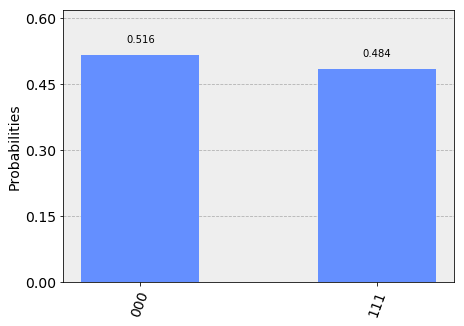

In [15]:
#To simulate this circuit, we use the qasm_simulator in Qiskit Aer. 
#Each run of this circuit will yield either the bitstring 000 or 111. 
#To build up statistics about the distribution of the bitstrings 
#(to, e.g., estimate $\mathrm{Pr}(000)$), 
#we need to repeat the circuit many times. 
#The number of times the circuit is repeated can be specified in the execute function, 
#via the shots keyword.

# Use Aer's qasm_simulator
backend_sim = BasicAer.get_backend('qasm_simulator')

# Execute the circuit on the qasm simulator.
# We've set the number of repeats of the circuit
# to be 1024, which is the default.
job_sim = execute(qc, backend_sim, shots=1024)

# Grab the results from the job.
result_sim = job_sim.result()

#In a result object, access the counts
#get_counts(circuit) - aggregated binary outcomes of the circuit submitted
counts = result_sim.get_counts(qc)
print(counts)

#Approximately 50 percent of the time the output bitstring is 000. 

#Qiskit also provides a function plot_histogram to view the outcomes
from qiskit.visualization import plot_histogram
plot_histogram(counts)

#The estimated outcome probabilities 
#$\mathrm{Pr}(000)$ and  $\mathrm{Pr}(111)$ 
#are computed by taking the aggregate counts and dividing by the number of shots 
#Try changing the shots keyword in the execute function to see how the estimated probabilities change.

In [16]:
#Running circuits using the IBMQ provider 
#To access IBMQ devices, we need an API token. 

#IBMQ provider lets one run the circuit on real devices or on our HPC simulator. 
from qiskit import IBMQ

#After generating your API token, 
#call: IBMQ.save_account('MY_TOKEN'). 
#This will store IBMQ credentials in a local file. 
#Unless your registration information has changed, we only need to do this once. 
#The available backends
MY_API_TOKEN='572f057faf2d93153592814e772f301325b332b27dac1fd311d516ba595d2f133d955a29eccb281cb08ae6204eea37bc7117d6d7d80a921f92ad6d1c709c1260'
IBMQ.enable_account(MY_API_TOKEN)
IBMQ.save_account(MY_API_TOKEN)
#You may now load your accounts by calling,
IBMQ.load_accounts(hub=None)

#Once your account has been loaded, you can view the list of backends available to you.
print("Available backends:")
IBMQ.backends()

/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/credentials/configrc.py:130: UserWarning: Credentials already present. Set overwrite=True to overwrite.
  warnings.warn('Credentials already present. '
/opt/conda/lib/python3.7/site-packages/qiskit/providers/ibmq/ibmqprovider.py:269: UserWarning: Credentials are already in use.
  warnings.warn('Credentials are already in use.')


Available backends:


[<IBMQBackend('ibmqx4') from IBMQ()>,
 <IBMQSimulator('ibmq_qasm_simulator') from IBMQ()>,
 <IBMQBackend('ibmqx2') from IBMQ()>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ()>]

In [17]:
#Running circuits on real devices
#Today's quantum information processors are small and noisy, but are advancing at a fast pace. 
#They provide a great opportunity to explore what noisy, intermediate-scale quantum (NISQ) computers can do.

#The IBMQ provider uses a queue to allocate the devices to users. 
#We now choose a device with the least busy queue which can support our program (has at least 3 qubits).
from qiskit.providers.ibmq import least_busy

large_enough_devices = IBMQ.backends(filters=lambda x: x.configuration().n_qubits < 10 and
                                                       not x.configuration().simulator)
backend = least_busy(large_enough_devices)
print("The best backend is " + backend.name())

The best backend is ibmqx4


In [ ]:
#To run the circuit on the backend, we need to specify the number of shots and 
#the number of credits we are willing to spend to run the circuit. 
#Then, we execute the circuit on the backend using the execute function.
from qiskit.tools.monitor import job_monitor
shots = 1024           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 3        # Maximum number of credits to spend on executions. 

job_exp = execute(qc, backend=backend, shots=shots, max_credits=max_credits)
job_monitor(job_exp)

Job Status: job is actively running 

In [ ]:
#job_exp has a .result() method 
#When the .result() method is called, the code block will wait until the job has finished 
#before releasing the cell.
result_exp = job_exp.result()
#Like before, the counts from the execution can be obtained using get_counts(qc)
counts_exp = result_exp.get_counts(qc)
plot_histogram([counts_exp,counts])

In [24]:
#Simulating circuits using a HPC simulator
#The IBMQ provider also comes with a remote optimized simulator called ibmq_qasm_simulator. 
#This remote simulator is capable of simulating up to 32 qubits. 
#It can be used the same way as the remote real backends.
simulator_backend = IBMQ.get_backend('ibmq_qasm_simulator', hub=None)
shots = 1024           # Number of shots to run the program (experiment); maximum is 8192 shots.
max_credits = 0        # Maximum number of credits to spend on executions. 
job_hpc = execute(qc, backend=simulator_backend, shots=shots, max_credits=max_credits)

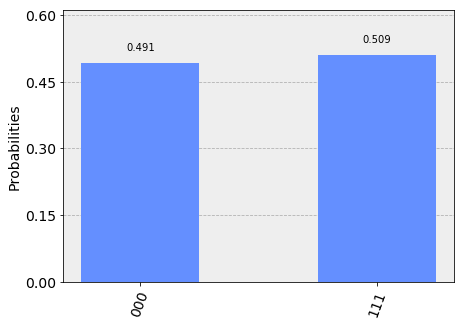

In [25]:
result_hpc = job_hpc.result()
counts_hpc = result_hpc.get_counts(qc)
plot_histogram(counts_hpc)

In [26]:
#Retrieving a previously run job
#If your experiment takes longer to run then you have time to wait around, 
#or if you simply want to retrieve old jobs back, 
#the IBMQ backends allow you to do that. 

#Note a job's ID:
jobID = job_exp.job_id()
print('JOB ID: {}'.format(jobID))

#Given a job ID, the job object can be later reconstructed from the backend using retrieve_job:
job_get=backend.retrieve_job(jobID)

#then the results can be obtained from the new job object.
job_get.result().get_counts(qc)

JOB ID: 5d08c5600b7c410011d8c4de


{'000': 335,
 '100': 111,
 '101': 67,
 '111': 348,
 '001': 21,
 '010': 30,
 '011': 74,
 '110': 38}

In [27]:
#Choose a backend - QC - an adhoc backend
my_backend = IBMQ.get_backend('ibmq_5_tenerife', hub='ibm-q')
#my_backend = IBMQ.get_backend('ibmq_16_melbourne')
#my_backend = IBMQ.get_backend('ibmqx4')
print(my_backend)
job = execute(circuit, backend=my_backend, shots=100)
print (job, job.job_id(), job.status())
result = job.result()
counts = result.get_counts()
print(counts)

ibmqx4
<qiskit.providers.ibmq.ibmqjob.IBMQJob object at 0x7f1c35b8eb00> 5d08c6fb648ce4001185d85c JobStatus.RUNNING
{'00': 58, '01': 11, '10': 1, '11': 30}
